In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.cross_validation import train_test_split

from scipy.ndimage.measurements import label

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from moviepy.editor import VideoFileClip
%matplotlib inline


C:\Users\uidj5502\AppData\Local\Continuum\Anaconda2\envs\conda_python3_env\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Explore the Training Data
def load_data():
    cars = glob.glob('./Training_Data/Full_Dataset/vehicles/**/*.png', recursive=True)
    notcars = glob.glob('./Training_Data/Full_Dataset/non-vehicles/**/*.png', recursive=True)
    
    return (cars, notcars)

In [3]:
cars, notcars = load_data()
print("Total Car Images found: ", len(cars))
print("Total Not-Car Images found: ", len(notcars))

Total Car Images found:  8792
Total Not-Car Images found:  8968


num of cars selected:  4
num of non-cars selected:  4


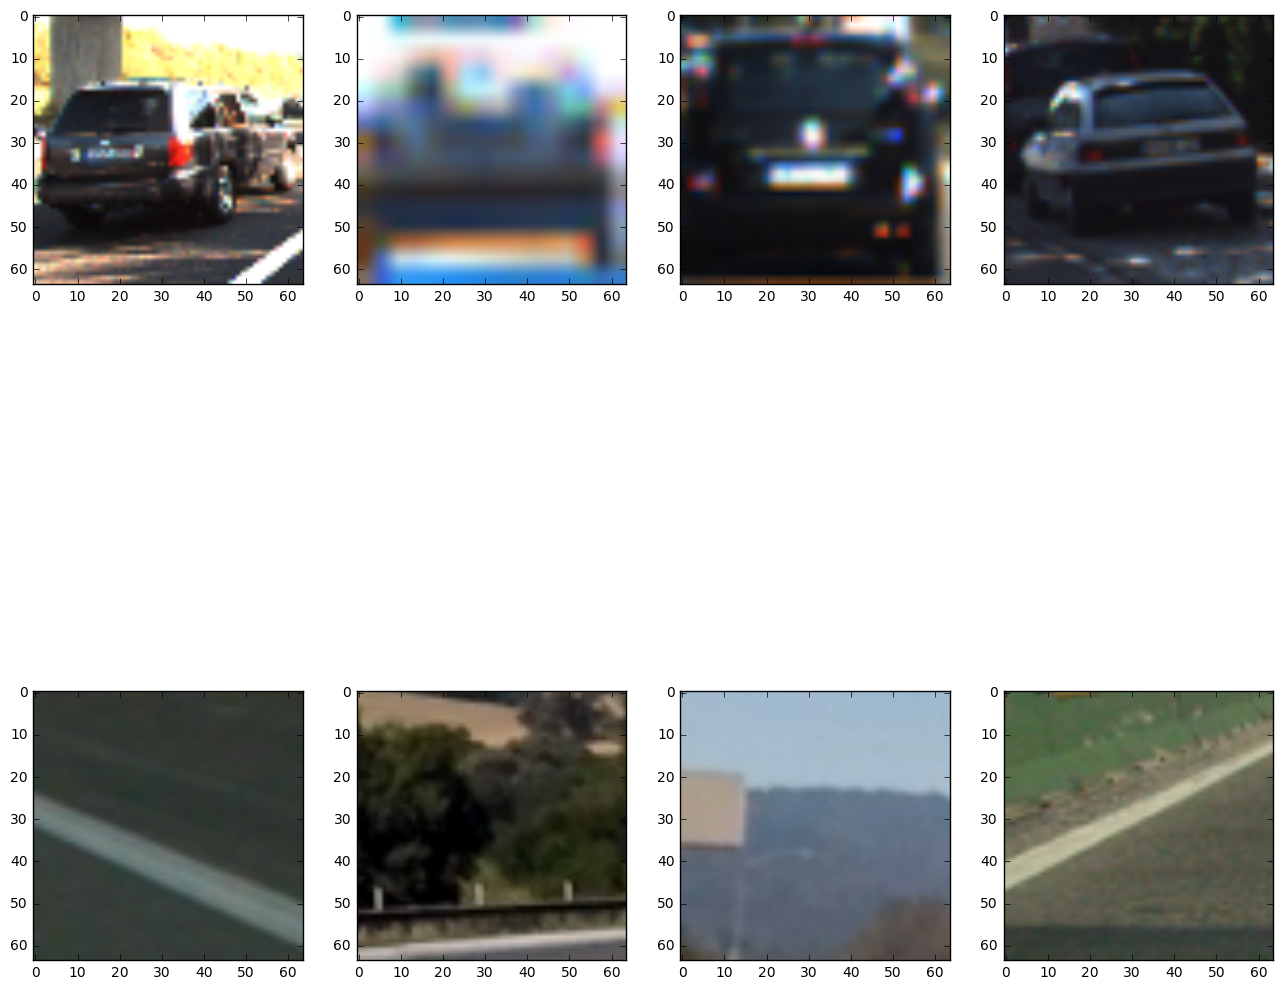

In [4]:
#visualize Car/Non-Car images

import random
num_to_select = 4   # set the number to select here.
cars_random_sample = random.sample(cars, num_to_select)
notcars_random_sample = random.sample(notcars, num_to_select)

print('num of cars selected: ', len(cars_random_sample))
print('num of non-cars selected: ', len(notcars_random_sample))

plt.subplots(2,num_to_select, figsize=(16,16))

for i, car in enumerate(cars_random_sample):
    plt.subplot(2,num_to_select, i+1)
    plt.imshow(mpimg.imread(car))

for i, notcar in enumerate(notcars_random_sample):
    plt.subplot(2,num_to_select, num_to_select+i+1)
    plt.imshow(mpimg.imread(notcar))

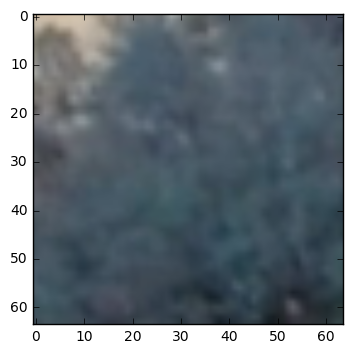

In [5]:
test_img = cv2.imread(random.sample(notcars,1)[0])
plt.imshow(test_img)

In [37]:
# Define a function to return HOG features and visualization

#@interact (img = fixed(test_img[:,:,0]), orient=9, pix_per_cell=8, cell_per_block=2, vis=False, feature_vec=True)
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

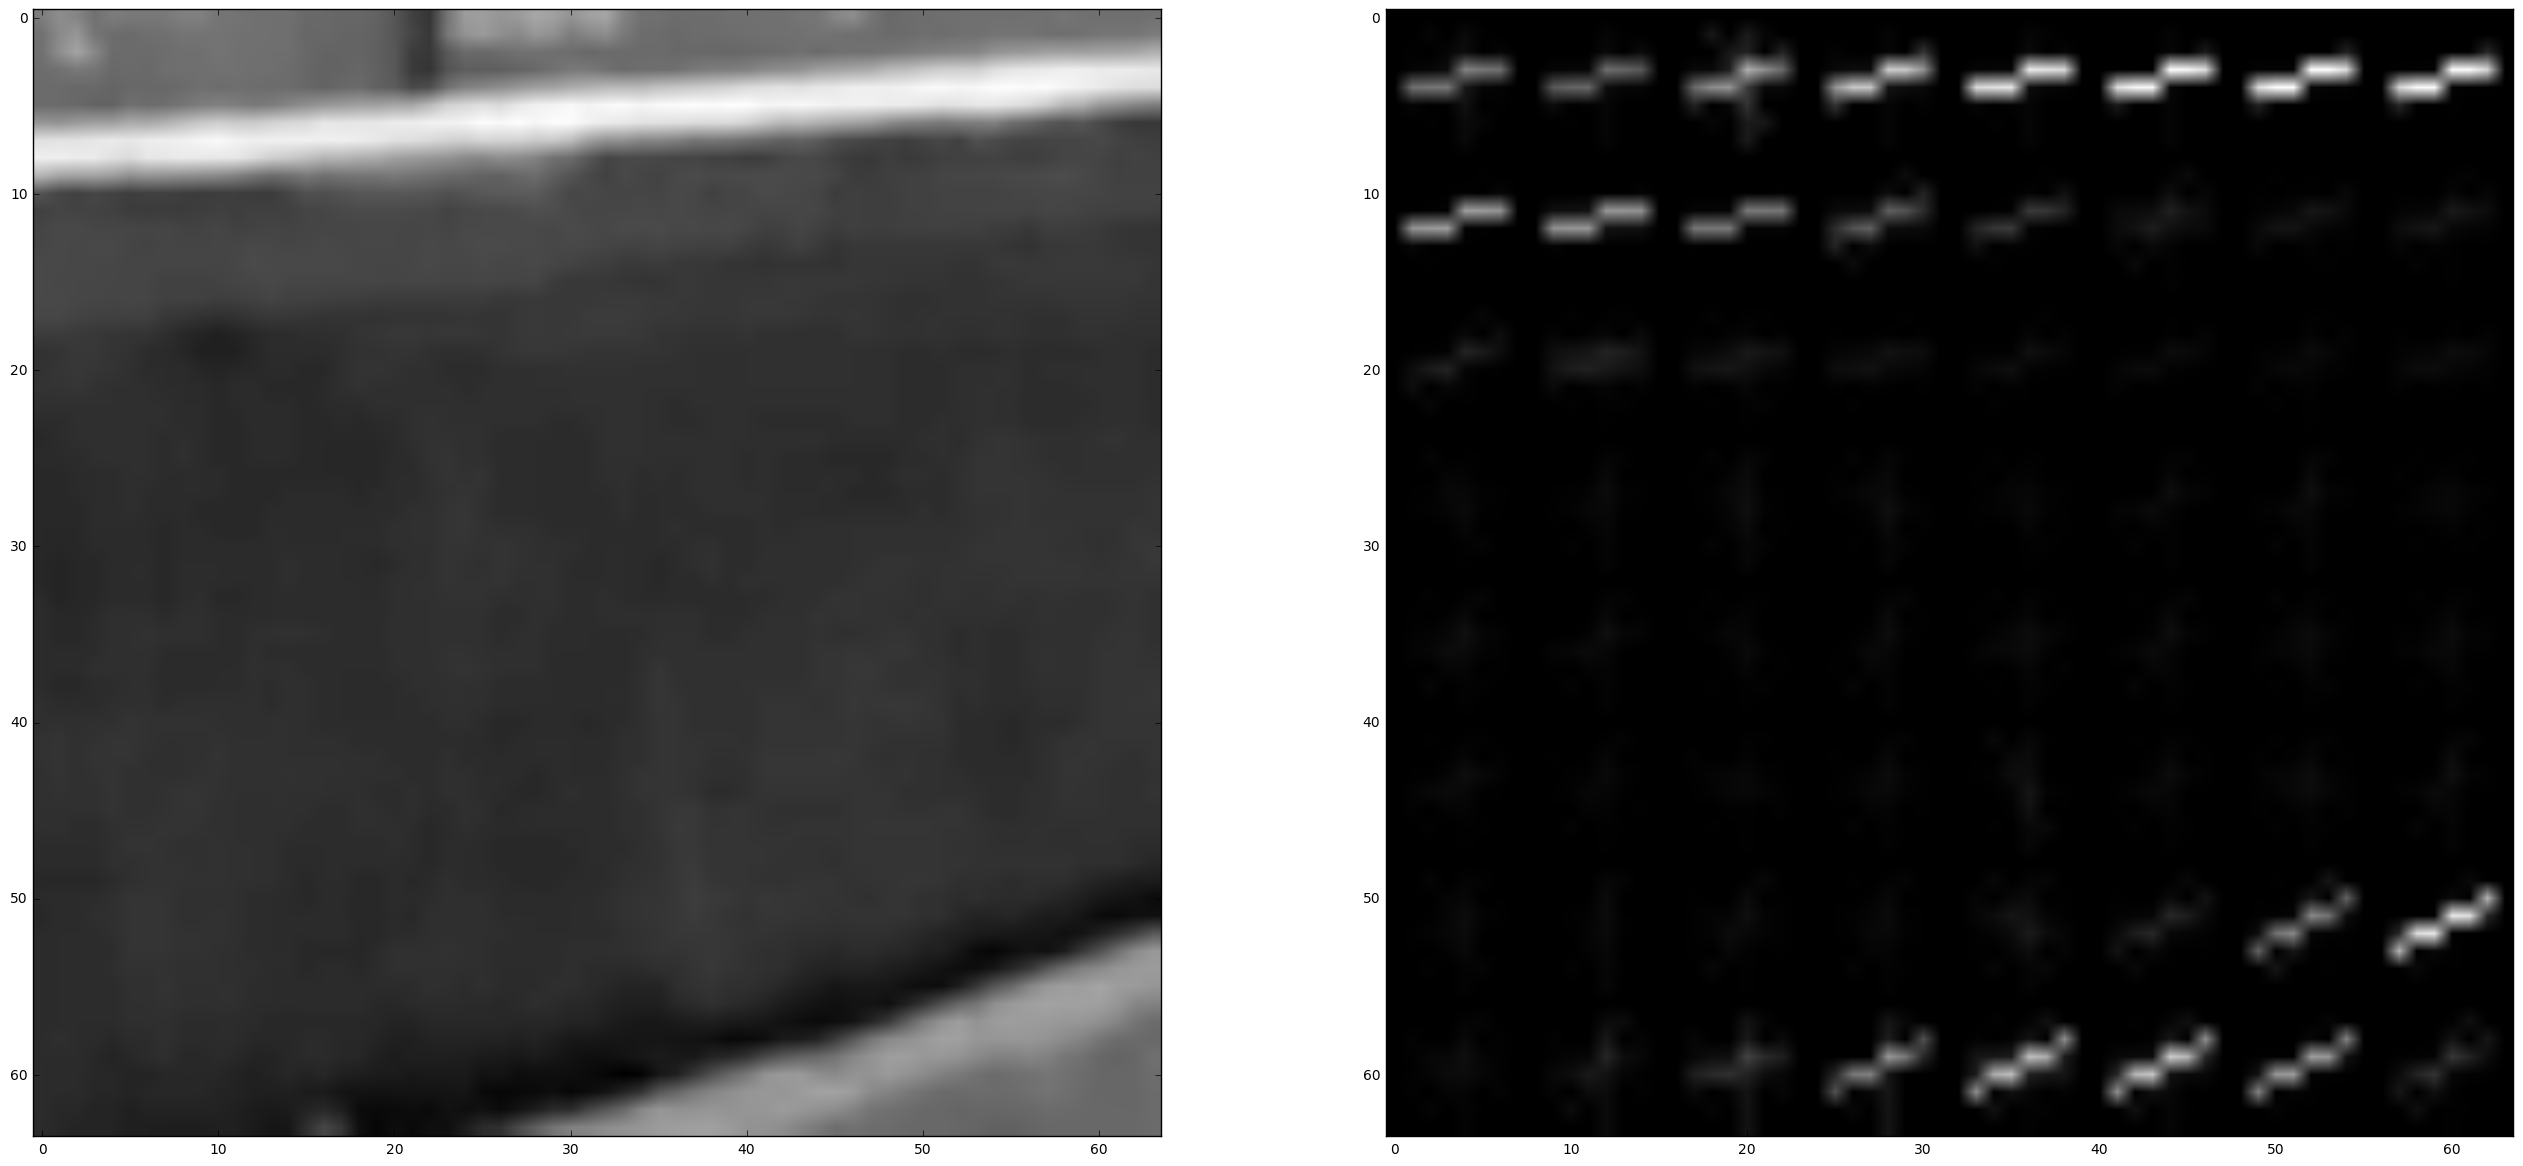

In [45]:
orient = 9
pix_per_cell = 8
cell_per_block = 2
img = cv2.imread(random.sample(notcars,1)[0])
feat, hog_img = get_hog_features(img[:,:,0], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

fig = plt.figure(figsize=(32,32))

plt.subplot(121)
plt.imshow(img[:,:,0], cmap='gray')

plt.subplot(122)
plt.imshow(hog_img,cmap='gray')

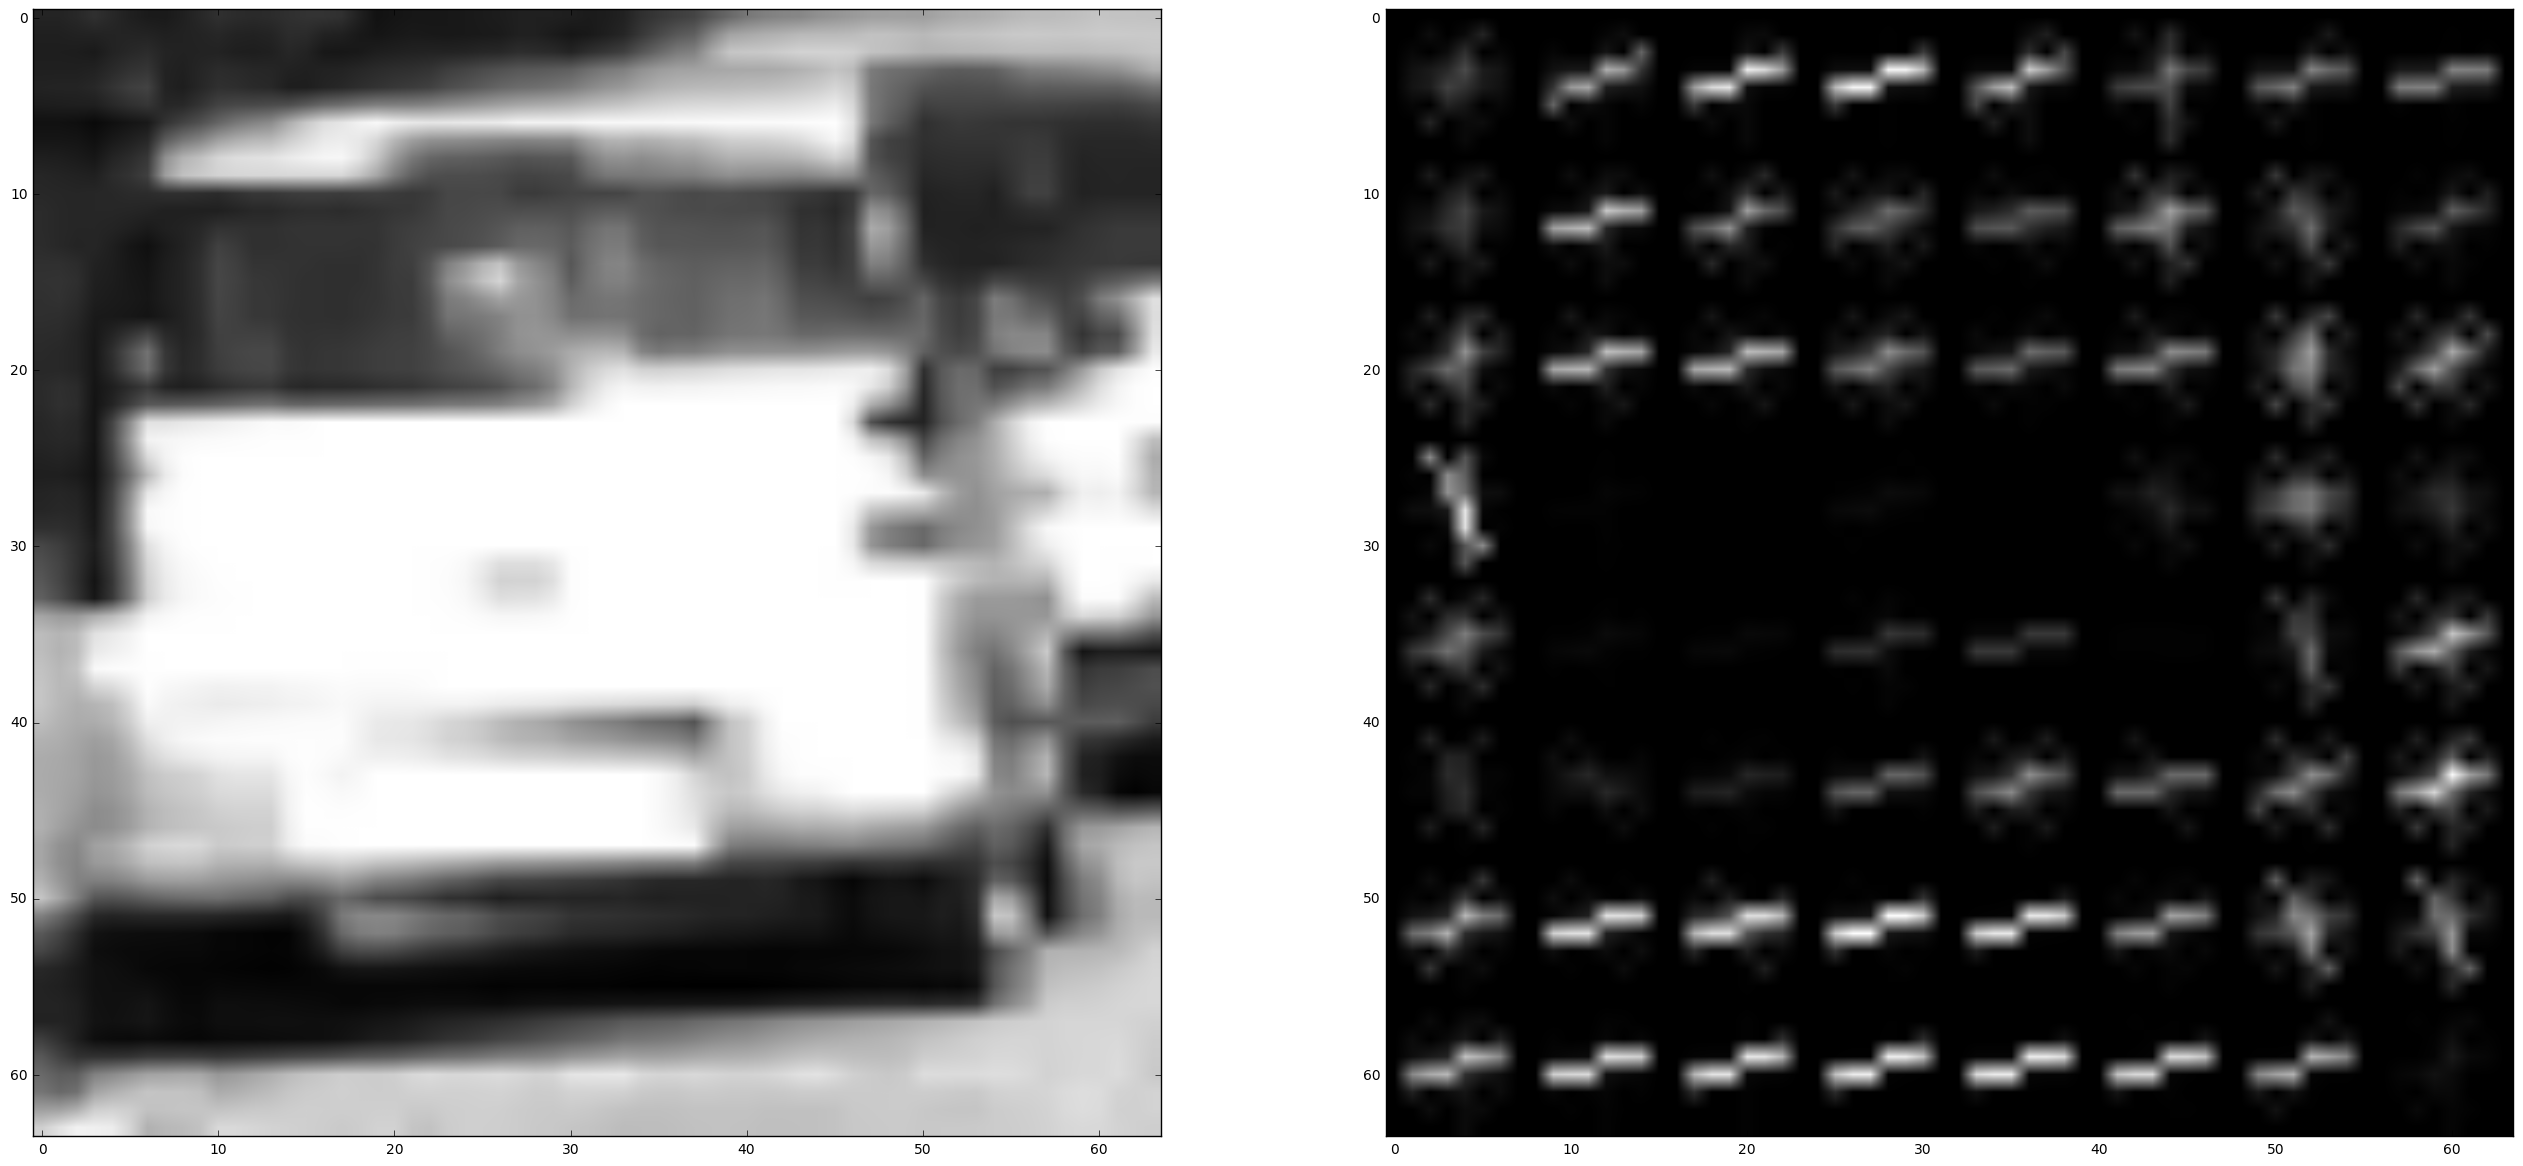

In [39]:
orient = 9
pix_per_cell = 8
cell_per_block = 2
img = cv2.imread(random.sample(cars,1)[0])
feat, hog_img = get_hog_features(img[:,:,0], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

fig = plt.figure(figsize=(32,32))

plt.subplot(121)
plt.imshow(img[:,:,0], cmap='gray')

plt.subplot(122)
plt.imshow(hog_img,cmap='gray')

In [42]:
# Convert color channels
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [43]:
color_space = 'YCrCb' # Other options are: RGB, HSV, LUV, HLS, YUV, YCrCb

orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block

hog_channel = 'ALL' # Other options are: 0, 1, 2

spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins

spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off


In [44]:
# extract features for all Car and Non Cars images.

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

print("Car Features found: ", len(car_features))
print("Not-Car Images found: ", len(notcar_features))

Car Features found:  8792
Not-Car Images found:  8968


In [46]:
#defind feature vector
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


In [47]:
print(np.mean(X, axis=0))
print(np.var(X, axis=0))

[ 0.34218971  0.49629162  0.48900812 ...,  0.01494758  0.01299672
  0.01534258]
[ 0.04732719  0.00110526  0.00181852 ...,  0.00021168  0.00017611
  0.00035107]


In [48]:
# preprocessing of feature - Zero mean and unit norm

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)


In [49]:
print(np.mean(scaled_X, axis=0))
print(np.var(scaled_X, axis=0))

[ -1.15398182e-16   1.56931525e-16   1.07445021e-16 ...,  -2.74071775e-15
  -3.40335868e-15  -2.58895758e-16]
[ 1.  1.  1. ...,  1.  1.  1.]


In [50]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

In [51]:
print('Total samples: ', len(scaled_X))
print('After Random Split into Train/Validation Dataset : 80/20')
print('Total Train/Lables samples:', len(X_train), len(y_train))
print('Total Validate/Lables samples:', len(X_test), len(y_test))

Total samples:  17760
After Random Split into Train/Validation Dataset : 80/20
Total Train/Lables samples: 14208 14208
Total Validate/Lables samples: 3552 3552


In [52]:
# Training:

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6108
4.95 Seconds to train SVC...


In [53]:
# Check the accuracy of the learned classifier
t1=time.time()
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t2=time.time()
print(round((t2-t1)/len(X_test)*1000, 4), 'mili seconds to test SVC...')


Test Accuracy of SVC =  0.9901
0.0194 mili seconds to test SVC...


In [54]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [82]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def get_vehicle_hypothesis(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):   
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)

    hot_windows = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                
                hot_windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return hot_windows

In [73]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


In [84]:
def process_single_image(image):

    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    debug_image = np.copy(image)
    hot_windows_current_frame = []
    
    scales       = [0.88, 1.60, 3.50]
    y_pos_start  = [420, 400, 380]
    y_pos_stop    = [510, 560, 660]

    for i in range(len(scales)):
        hot_windows = get_vehicle_hypothesis(image, y_pos_start[i], y_pos_stop[i], scales[i], svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        debug_image = draw_boxes(debug_image, hot_windows, color = (0, 255, 0), thick = 4)
        hot_windows_current_frame = hot_windows_current_frame + hot_windows
    
    cv2.imwrite("multiscale_approach.jpg",debug_image)
    
    heat_threshold = 2 
            
    # Add heat to each box in box list
    heat = add_heat(heat, hot_windows_current_frame)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, heat_threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    vehicle_detection_result = draw_labeled_bboxes(np.copy(image), labels)

    fig = plt.figure()
    plt.subplot(221)
    plt.imshow(vehicle_detection_result)
    plt.title('Car Positions')
    plt.subplot(222)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    plt.subplot(223)
    plt.imshow(debug_image)
    plt.title('debug_image')
    fig.tight_layout()
    plt.show()
    
    cv2.imwrite("heat_map.jpg", heatmap)
    cv2.imwrite("vehicle_detection.jpg", vehicle_detection_result)
    
    return vehicle_detection_result


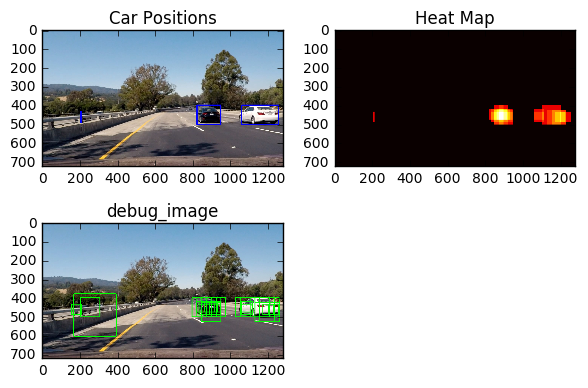

True

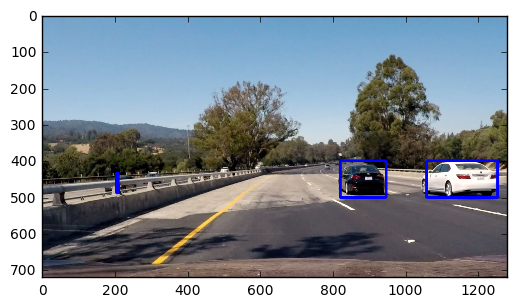

In [85]:
# Test on a single image

image = mpimg.imread('test_images/test4.jpg')
single_img_result = process_single_image(image)
plt.imshow(single_img_result)
cv2.imwrite("result_01_multi_win.jpg", single_img_result)

In [86]:
def process_image(image):

    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    debug_image = np.copy(image)
    hot_windows_current_frame = []
    
    scales       = [0.88, 1.60, 3.50]
    y_pos_start  = [420, 400, 380]
    y_pos_stop    = [510, 560, 660]

    for i in range(len(scales)):
        hot_windows = get_vehicle_hypothesis(image, y_pos_start[i], y_pos_stop[i], scales[i], svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        debug_image = draw_boxes(debug_image, hot_windows, color = (0, 255, 0), thick = 4)
        hot_windows_current_frame = hot_windows_current_frame + hot_windows

    # Average single image detection results from last few frames        
    global hot_windows_pool
    avg_over_last_frames = 10
    heat_threshold = 10 

    hot_windows_pool.append(hot_windows_current_frame)

    avg_hot_windows = [] # holds hot windows of last few frames.
    
    if(len(hot_windows_pool) > avg_over_last_frames):
        for cnt in range(1, avg_over_last_frames+1):
            for windows in hot_windows_pool[-cnt]:
                avg_hot_windows.append(windows)
            
    # Add heat to each box in box list
    heat = add_heat(heat, avg_hot_windows)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, heat_threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    vehicle_detection_result = draw_labeled_bboxes(np.copy(image), labels)

    return vehicle_detection_result


In [64]:
# Global variable to store hot window results of last 
hot_windows_pool = []

video_output = 'project_video_out.mp4'
video_input  = VideoFileClip('project_video.mp4')
#video_input  = VideoFileClip('clip.mp4')
video_clip = video_input.fl_image(process_image)
video_clip.write_videofile(video_output, audio=False)


[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████████████████████████████████▉| 1260/1261 [12:24<00:00,  1.78it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 



In [65]:
from IPython.display import HTML
# Visualize video result
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))